In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("data_censored.csv")

# Display the first few rows
df.head()


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0


In [2]:
# Check basic info
df.info()

# Summary statistics
df.describe()

# Check for missing values
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         725 non-null    int64  
 1   period     725 non-null    int64  
 2   treatment  725 non-null    int64  
 3   x1         725 non-null    int64  
 4   x2         725 non-null    float64
 5   x3         725 non-null    int64  
 6   x4         725 non-null    float64
 7   age        725 non-null    int64  
 8   age_s      725 non-null    float64
 9   outcome    725 non-null    int64  
 10  censored   725 non-null    int64  
 11  eligible   725 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 68.1 KB


id           0
period       0
treatment    0
x1           0
x2           0
x3           0
x4           0
age          0
age_s        0
outcome      0
censored     0
eligible     0
dtype: int64

In [3]:
import statsmodels.api as sm
import numpy as np

# Define independent variables for censoring model
X_censor = df[['x2', 'x1']]
X_censor = sm.add_constant(X_censor)

# Define dependent variable (censored indicator)
y_censor = df['censored']

# Fit logistic regression for IPCW
ipcw_model = sm.Logit(y_censor, X_censor).fit()
df['censor_prob'] = ipcw_model.predict(X_censor)

# Compute IPCW weights
df['ipcw_weight'] = 1 / (1 - df['censor_prob'])

# Prevent extreme values (Winsorization)
df['ipcw_weight'] = np.clip(df['ipcw_weight'], 0, df['ipcw_weight'].quantile(0.99))

# Debug: Check if `ipcw_weight` is correctly assigned
df[['censored', 'censor_prob', 'ipcw_weight']].head()


Optimization terminated successfully.
         Current function value: 0.267425
         Iterations 7


,censored,censor_prob,ipcw_weight
0,0,0.085615,1.093631
1,0,0.051819,1.054651
2,0,0.080719,1.087807
3,0,0.099556,1.110563
4,0,0.056993,1.060438


In [4]:
from sklearn.preprocessing import StandardScaler

# Select relevant features for clustering
features = df[['age', 'x1', 'x2', 'x3', 'x4']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


In [5]:
from sklearn.cluster import KMeans

# Apply K-Means clustering (choose 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Check cluster distribution
df['cluster'].value_counts()


cluster
0    294
2    216
1    215
Name: count, dtype: int64

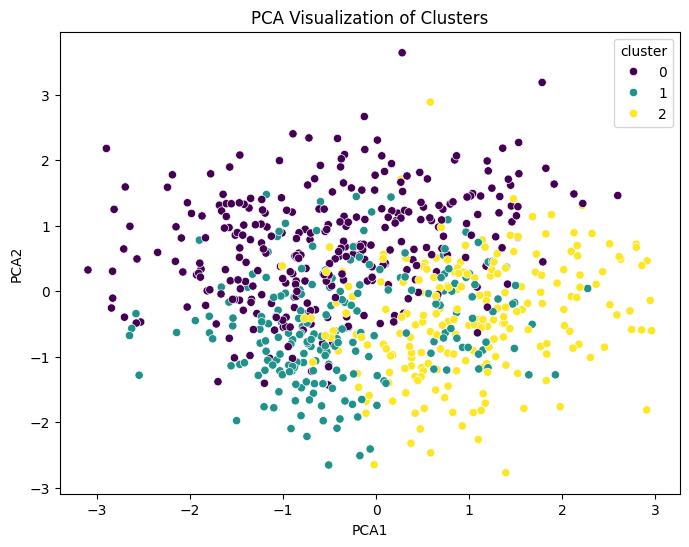

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df['PCA1'], df['PCA2'] = pca_result[:, 0], pca_result[:, 1]

# Plot PCA visualization of clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['PCA1'], y=df['PCA2'], hue=df['cluster'], palette='viridis')
plt.title('PCA Visualization of Clusters')
plt.show()


treatment         0         1
cluster                      
0          0.020408  0.006803
1          0.024590  0.010753
2          0.017094  0.010101


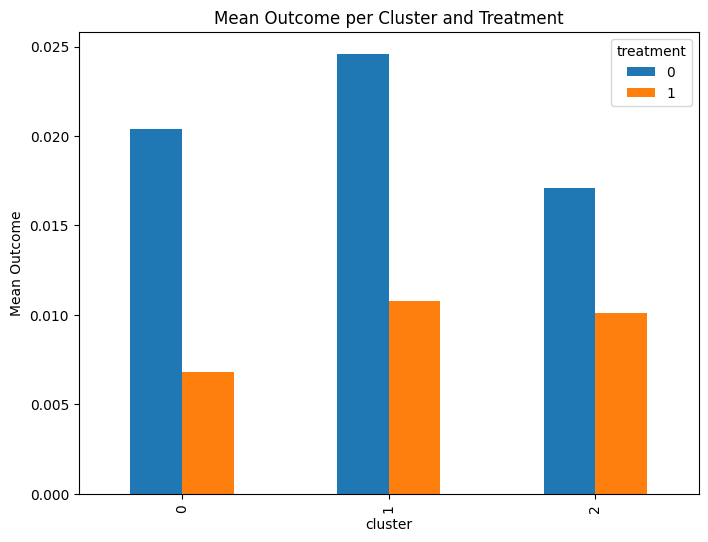

In [7]:
# Compare clusters with treatment outcomes
cluster_treatment_outcome = df.groupby(['cluster', 'treatment'])['outcome'].mean().unstack()

# Display cluster treatment effects
print(cluster_treatment_outcome)

# Visualize the relationship
cluster_treatment_outcome.plot(kind='bar', figsize=(8,6))
plt.title('Mean Outcome per Cluster and Treatment')
plt.ylabel('Mean Outcome')
plt.show()
